In [2]:
import numpy as np
import matplotlib.pyplot as plt
print("Matplotlib imported successfully!")
from inclinometer_sim import InclinometerSim
print("InclinometerSim imported successfully!")
from motion_profiles import (
    static_orientation,
    sinusoidal_orientation,
    pure_linear_accel_world,
    pure_angular_motion,
    mixed_linear_angular_demo,
    high_freq_vibration_profile,
 )
print("Motion profiles imported successfully!")
from ekf_inclinometer import InclinometerEKF, EKFConfig
print("EKF Inclinometer imported successfully!")

Matplotlib imported successfully!
InclinometerSim imported successfully!
Motion profiles imported successfully!
EKF Inclinometer imported successfully!


In [3]:
sim = InclinometerSim(accel_noise_std=(0, 0, 0))
sim.set_orientation(0.1, 0.0, 0.0)  # small roll, no pitch, no yaw
sim.set_linear_accel_body(0.0, 0.0, 0.0)
acc = sim.read_accel()
roll_acc, pitch_acc = InclinometerSim.roll_pitch_from_accel(acc)
print("accel:", acc)
print("roll_acc (deg) =", np.rad2deg(roll_acc), "pitch_acc (deg) =", np.rad2deg(pitch_acc))

accel: [ 0.          0.97936582 -9.76099086]
roll_acc (deg) = 5.729577951308233 pitch_acc (deg) = -0.0


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from inclinometer_sim import InclinometerSim
from motion_profiles import (
    static_orientation,
    sinusoidal_orientation,
    pure_linear_accel_world,
    pure_angular_motion,
    mixed_linear_angular_demo,
)
from ekf_inclinometer import InclinometerEKF, EKFConfig

rad2deg = np.rad2deg

def run_simulation(profile, T=10.0, dt=0.01, title=""):
    accel_density_ug = 400.0
    accel_density_ms2 = (accel_density_ug * 1e-6) * 9.81  # m/s²/√Hz
    fs = 100.0  # Hz
    accel_std = accel_density_ms2 * np.sqrt(fs / 2.0)

    gyro_rms_deg = 0.05  # °/s-rms (from datasheet)
    gyro_std = np.deg2rad(gyro_rms_deg)  # rad/s

    sim = InclinometerSim(
        accel_noise_std=(accel_std, accel_std, accel_std),
        gyro_noise_std=(gyro_std, gyro_std, gyro_std)
    )
    ekf = InclinometerEKF(EKFConfig(
        q_bias=1e-7,   # slightly more bias adaptability
        q_pitch=5e-6,
        q_roll=1e-4,
        r_pitch= 0.0007440621286495156*5, 
        r_roll=0.00011078655455816213))

    N = int(T / dt)
    t = np.linspace(0.0, T, N)

    roll_true = np.zeros(N)
    pitch_true = np.zeros(N)
    yaw_true = np.zeros(N)

    roll_est = np.zeros(N)
    pitch_est = np.zeros(N)
    bx_est = np.zeros(N)
    by_est = np.zeros(N)
    bz_est = np.zeros(N)

    roll_meas_acc = np.zeros(N)
    pitch_meas_acc = np.zeros(N)

    accel_log = np.zeros((N, 3))
    gyro_log = np.zeros((N, 3))

    for k in range(N):
        tk = t[k]
        (roll, pitch, yaw), (ax_body, ay_body, az_body), (wx, wy, wz) = profile(tk)

        # Set true state in simulator
        sim.set_orientation(roll, pitch, yaw)
        sim.set_angular_velocity_body(wx, wy, wz)

        # Treat provided accel as body-frame linear accel
        sim.set_linear_accel_body(ax_body, ay_body, az_body)

        # Sensor readings
        accel_meas = sim.read_accel()
        gyro_meas = sim.read_gyro()

        # EKF prediction and update
        ekf.predict(gyro_meas, dt)
        roll_acc, pitch_acc = InclinometerSim.roll_pitch_from_accel(accel_meas)
        ekf.update((roll_acc, pitch_acc))

        # Log
        roll_true[k] = roll
        pitch_true[k] = pitch
        yaw_true[k] = yaw
        roll_meas_acc[k] = roll_acc
        pitch_meas_acc[k] = pitch_acc
        accel_log[k] = accel_meas
        gyro_log[k] = gyro_meas

        roll_est[k], pitch_est[k], bx_est[k], by_est[k], bz_est[k] = ekf.get_state()

    # Plot angles (deg) and errors (deg)
    fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

    # Roll: true vs accel vs EKF
    axs[0, 0].plot(t, rad2deg(roll_true), label="roll true", color="C0")
    axs[0, 0].plot(t, rad2deg(roll_meas_acc), "--", label="roll from accel", color="C1")
    axs[0, 0].plot(t, rad2deg(roll_est), ":", label="roll EKF", color="C2")
    axs[0, 0].set_ylabel("Roll [deg]")
    axs[0, 0].legend()

    # Pitch: true vs accel vs EKF
    axs[0, 1].plot(t, rad2deg(pitch_true), label="pitch true", color="C0")
    axs[0, 1].plot(t, rad2deg(pitch_meas_acc), "--", label="pitch from accel", color="C1")
    axs[0, 1].plot(t, rad2deg(pitch_est), ":", label="pitch EKF", color="C2")
    axs[0, 1].set_ylabel("Pitch [deg]")
    axs[0, 1].legend()

    # Roll error: accel and EKF vs true
    roll_err_acc = rad2deg(roll_meas_acc - roll_true)
    roll_err_ekf = rad2deg(roll_est - roll_true)
    axs[1, 0].plot(t, roll_err_acc, "--", label="roll error accel", color="C1")
    axs[1, 0].plot(t, roll_err_ekf, ":", label="roll error EKF", color="C2")
    axs[1, 0].set_xlabel("Time [s]")
    axs[1, 0].set_ylabel("Roll error [deg]")
    axs[1, 0].legend()

    # Pitch error: accel and EKF vs true
    pitch_err_acc = rad2deg(pitch_meas_acc - pitch_true)
    pitch_err_ekf = rad2deg(pitch_est - pitch_true)
    axs[1, 1].plot(t, pitch_err_acc, "--", label="pitch error accel", color="C1")
    axs[1, 1].plot(t, pitch_err_ekf, ":", label="pitch error EKF", color="C2")
    axs[1, 1].set_xlabel("Time [s]")
    axs[1, 1].set_ylabel("Pitch error [deg]")
    axs[1, 1].legend()

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

    # Print final state comparison
    roll_true_final = roll_true[-1]
    pitch_true_final = pitch_true[-1]
    roll_acc_final = roll_meas_acc[-1]
    pitch_acc_final = pitch_meas_acc[-1]
    roll_est_final, pitch_est_final, bx_final, by_final, bz_final = ekf.get_state()

    print("Final true angles   (deg): roll = {:.3f}, pitch = {:.3f}".format(
        rad2deg(roll_true_final), rad2deg(pitch_true_final)
    ))
    print("Final accel angles  (deg): roll = {:.3f}, pitch = {:.3f}".format(
        rad2deg(roll_acc_final), rad2deg(pitch_acc_final)
    ))
    print("Final EKF angles    (deg): roll = {:.3f}, pitch = {:.3f}".format(
        rad2deg(roll_est_final), rad2deg(pitch_est_final)
    ))
    print("Final EKF biases (rad/s): bx = {:.4f}, by = {:.4f}, bz = {:.4f}".format(
        bx_final, by_final, bz_final
    ))

    return {
        "t": t,
        "roll_true": roll_true,
        "pitch_true": pitch_true,
        "yaw_true": yaw_true,
        "roll_meas_acc": roll_meas_acc,
        "pitch_meas_acc": pitch_meas_acc,
        "roll_est": roll_est,
        "pitch_est": pitch_est,
        "bx_est": bx_est,
        "by_est": by_est,
        "bz_est": bz_est,
        "roll_err_acc": roll_err_acc,
        "roll_err_ekf": roll_err_ekf,
        "pitch_err_acc": pitch_err_acc,
        "pitch_err_ekf": pitch_err_ekf,
        "accel": accel_log,
        "gyro": gyro_log,
    }

## Scenario 1: Static orientation (motionless)

The inclinometer is fixed in space with a constant orientation.

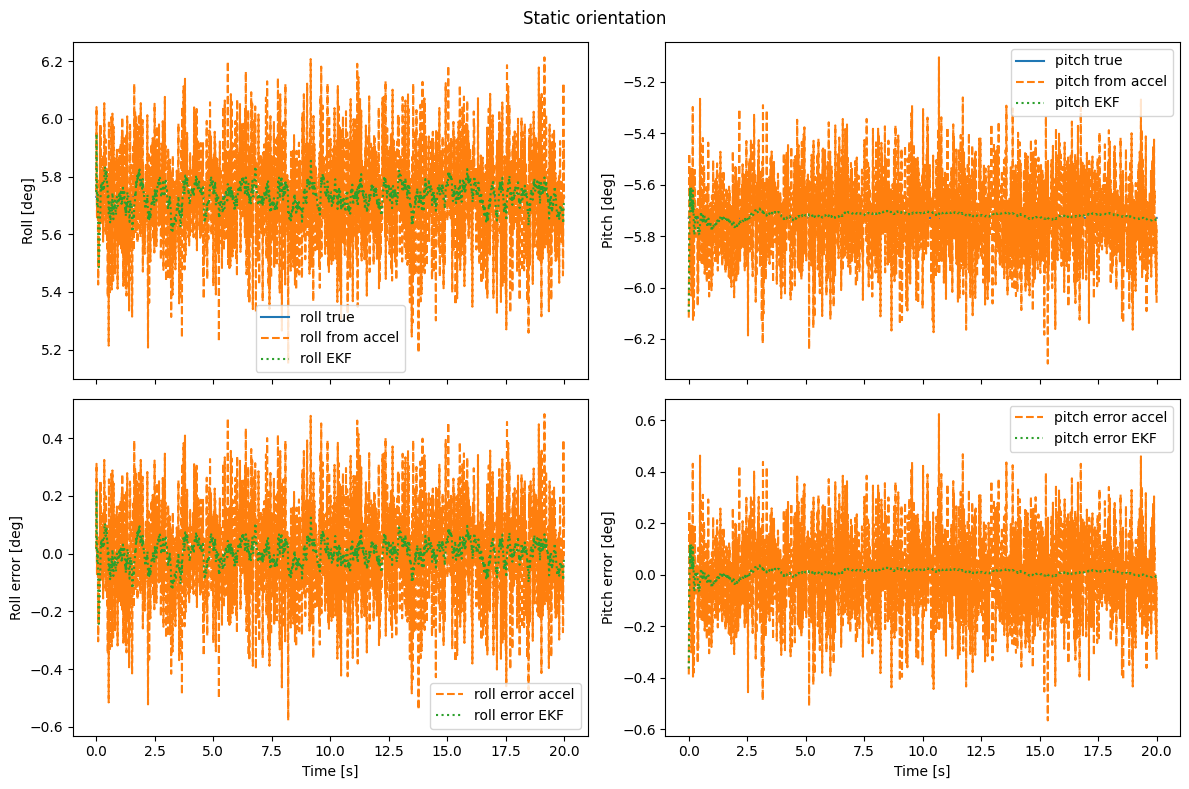

Final true angles   (deg): roll = 5.730, pitch = -5.730
Final accel angles  (deg): roll = 5.819, pitch = -6.059
Final EKF angles    (deg): roll = 5.718, pitch = -5.740
Final EKF biases (rad/s): bx = 0.0343, by = 0.0344, bz = -0.0162


{'t': array([0.00000000e+00, 1.00050025e-02, 2.00100050e-02, ...,
        1.99799900e+01, 1.99899950e+01, 2.00000000e+01], shape=(2000,)),
 'roll_true': array([0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1], shape=(2000,)),
 'pitch_true': array([-0.1, -0.1, -0.1, ..., -0.1, -0.1, -0.1], shape=(2000,)),
 'yaw_true': array([0., 0., 0., ..., 0., 0., 0.], shape=(2000,)),
 'roll_meas_acc': array([0.10030209, 0.10543541, 0.10022163, ..., 0.0999002 , 0.10330957,
        0.10155808], shape=(2000,)),
 'pitch_meas_acc': array([-0.10676347, -0.10332826, -0.0956389 , ..., -0.10519256,
        -0.10052292, -0.10575435], shape=(2000,)),
 'roll_est': array([0.10029102, 0.10380065, 0.10208268, ..., 0.09924008, 0.0996176 ,
        0.09979608], shape=(2000,)),
 'pitch_est': array([-0.10636632, -0.10464264, -0.10118212, ..., -0.10014661,
        -0.10013983, -0.10017511], shape=(2000,)),
 'bx_est': array([-0.00099881, -0.14855924,  0.02446156, ...,  0.03416283,
         0.03423341,  0.03430522], shape=(2000,)),
 'by

In [5]:
profile = static_orientation((0.1, -0.1, 0.0))
run_simulation(profile, T=20.0, dt=0.01, title="Static orientation")

## Scenario 2: Sinusoidal small-angle roll and pitch

Small oscillatory motion around zero orientation with optional yaw rate.



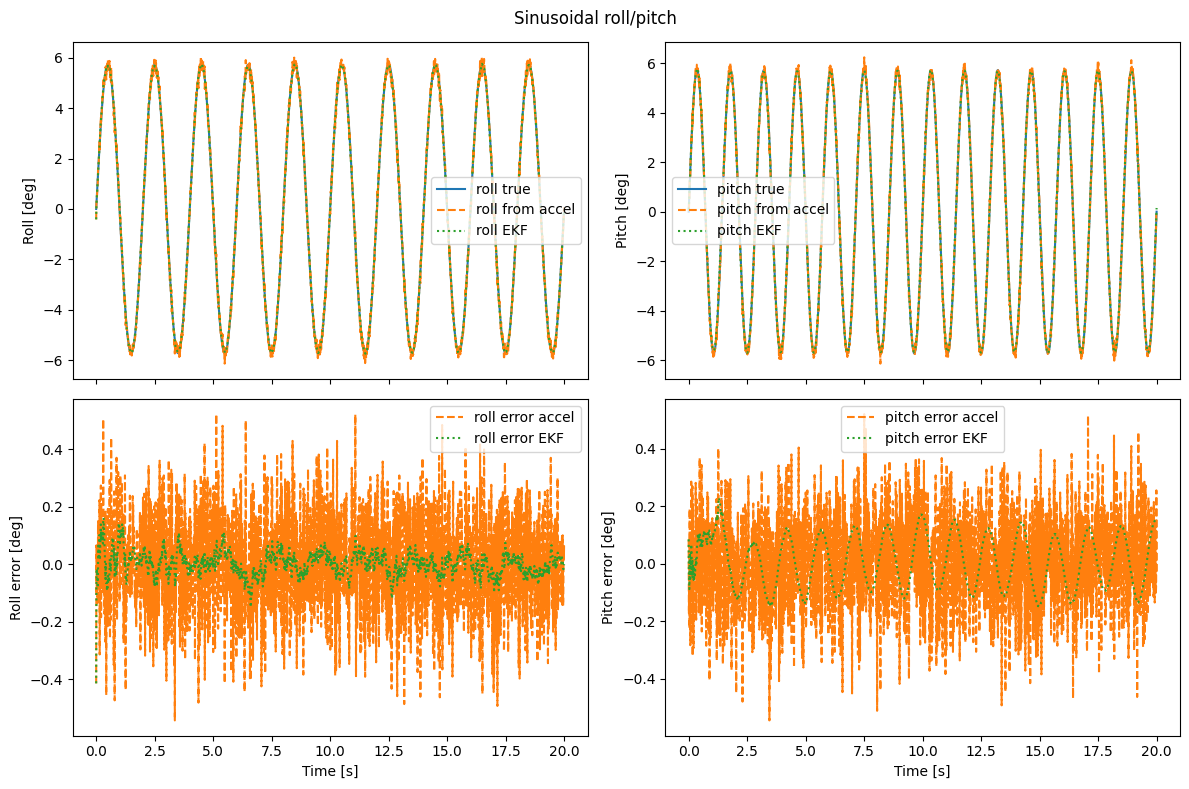

Final true angles   (deg): roll = -0.000, pitch = -0.000
Final accel angles  (deg): roll = 0.071, pitch = -0.029
Final EKF angles    (deg): roll = 0.000, pitch = 0.151
Final EKF biases (rad/s): bx = 0.0400, by = 0.0399, bz = 0.0362


{'t': array([0.00000000e+00, 1.00050025e-02, 2.00100050e-02, ...,
        1.99799900e+01, 1.99899950e+01, 2.00000000e+01], shape=(2000,)),
 'roll_true': array([ 0.00000000e+00,  3.14264671e-03,  6.28218891e-03, ...,
        -6.28218891e-03, -3.14264671e-03, -2.44929360e-16], shape=(2000,)),
 'pitch_true': array([ 0.00000000e+00,  4.39900992e-03,  8.78950306e-03, ...,
        -8.78950306e-03, -4.39900992e-03, -3.42901104e-16], shape=(2000,)),
 'yaw_true': array([0., 0., 0., ..., 0., 0., 0.], shape=(2000,)),
 'roll_meas_acc': array([-0.00722628,  0.00428743,  0.0052213 , ..., -0.00517984,
        -0.00280608,  0.00124214], shape=(2000,)),
 'pitch_meas_acc': array([ 1.46284836e-03,  1.36333561e-03,  7.07180768e-03, ...,
        -1.00621383e-02,  4.50642630e-05, -4.99949796e-04], shape=(2000,)),
 'roll_est': array([-7.22508746e-03,  1.54770693e-03,  6.02486255e-03, ...,
        -6.45031578e-03, -3.26701980e-03,  4.77293593e-07], shape=(2000,)),
 'pitch_est': array([ 0.00147523,  0.0038039 

In [6]:
profile = sinusoidal_orientation(roll_amp=0.1, roll_freq=0.5, pitch_amp=0.1, pitch_freq=0.7, yaw_rate=0.0)
run_simulation(profile, T=20.0, dt=0.01, title="Sinusoidal roll/pitch")

## Scenario 3: Pure angular rotation

Body rotates with a baseline yaw rate and small roll oscillation, no linear acceleration in body frame.

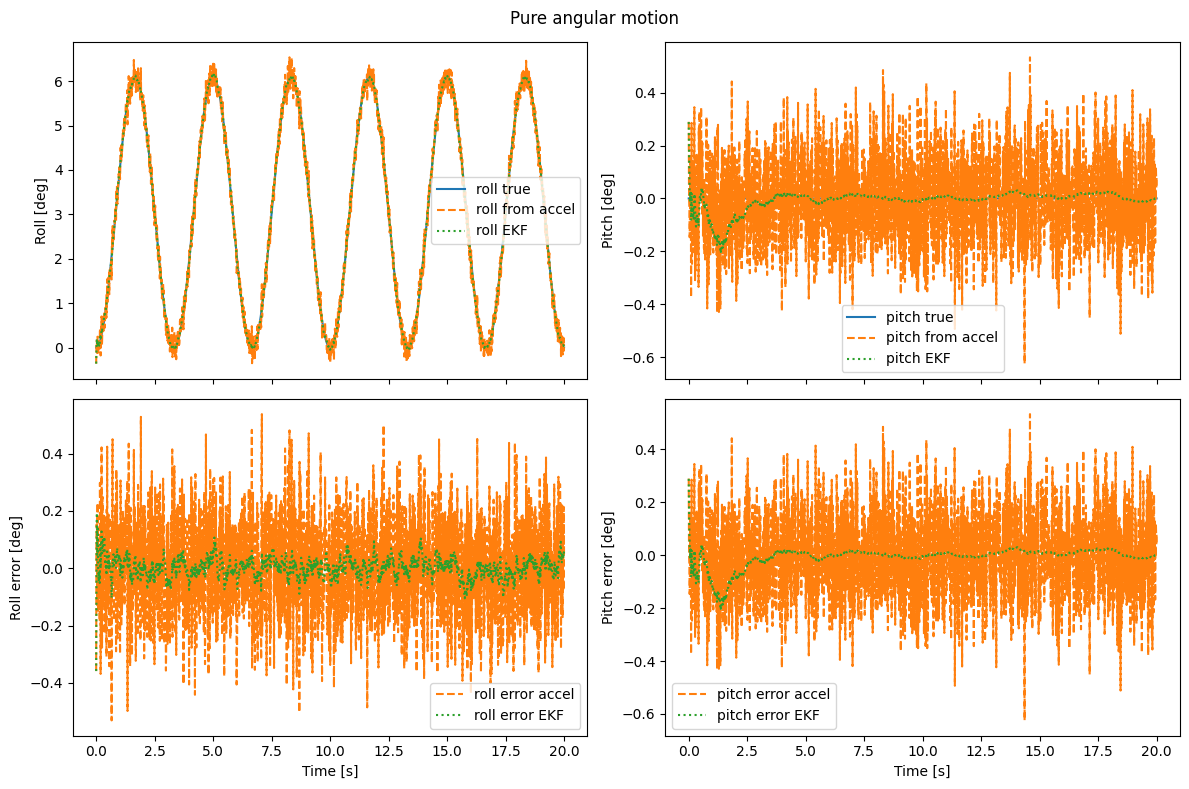

Final true angles   (deg): roll = 0.000, pitch = 0.000
Final accel angles  (deg): roll = 0.037, pitch = 0.090
Final EKF angles    (deg): roll = 0.054, pitch = 0.002
Final EKF biases (rad/s): bx = 0.0399, by = 0.0397, bz = 0.3335


{'t': array([0.00000000e+00, 1.00050025e-02, 2.00100050e-02, ...,
        1.99799900e+01, 1.99899950e+01, 2.00000000e+01], shape=(2000,)),
 'roll_true': array([0.00000000e+00, 9.43393020e-06, 3.77323656e-05, ...,
        3.77323656e-05, 9.43393020e-06, 0.00000000e+00], shape=(2000,)),
 'pitch_true': array([0., 0., 0., ..., 0., 0., 0.], shape=(2000,)),
 'yaw_true': array([0.00000000e+00, 3.00150075e-03, 6.00300150e-03, ...,
        5.99399700e+00, 5.99699850e+00, 6.00000000e+00], shape=(2000,)),
 'roll_meas_acc': array([-0.00625496,  0.00032719,  0.00270828, ..., -0.00130245,
         0.00374296,  0.00063967], shape=(2000,)),
 'pitch_meas_acc': array([ 0.00505482,  0.00102791, -0.00024233, ...,  0.00136278,
         0.00067207,  0.00156984], shape=(2000,)),
 'roll_est': array([-0.00625422, -0.00179021,  0.00196851, ...,  0.00072863,
         0.0009866 ,  0.00094405], shape=(2000,)),
 'pitch_est': array([5.03754519e-03, 3.33963080e-03, 2.29988623e-03, ...,
        1.51905600e-05, 2.18967

In [7]:
profile = pure_angular_motion(base_rates=(0.0, 0.0, 0.3), oscillatory_rates=(0.1, 0.0, 0.0), osc_freq=0.3)
run_simulation(profile, T=20.0, dt=0.01, title="Pure angular motion")

## Scenario 4: Mixed linear and angular motion demo

Combined yaw motion, small roll oscillation, and forward/backward linear acceleration.



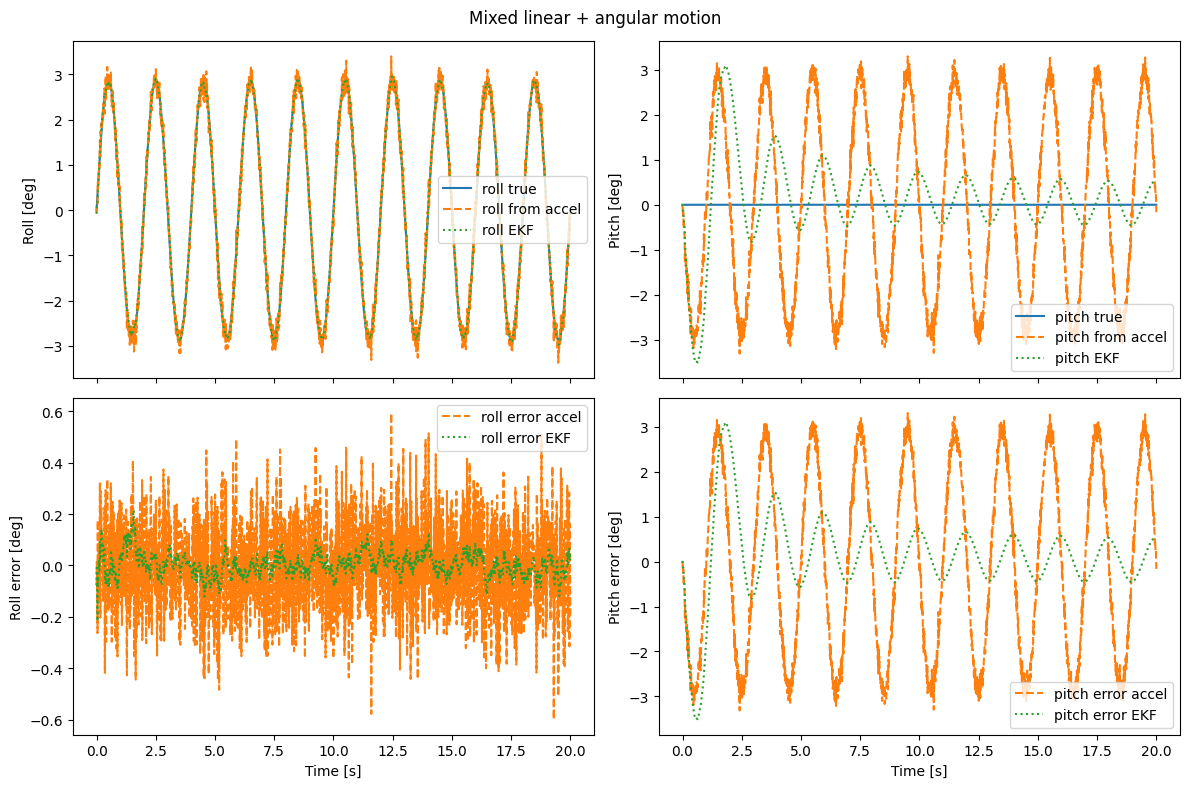

Final true angles   (deg): roll = -0.000, pitch = 0.000
Final accel angles  (deg): roll = -0.189, pitch = -0.165
Final EKF angles    (deg): roll = 0.008, pitch = 0.513
Final EKF biases (rad/s): bx = 0.0399, by = 0.0389, bz = 0.2017


In [8]:
profile = mixed_linear_angular_demo()
result_mixed = run_simulation(profile, T=20.0, dt=0.01, title="Mixed linear + angular motion")

## Scenario 5: High-frequency vibration with slow pitch drift

Small high-frequency linear accelerations (vibration) along x with a very slow, constant-rate pitch rotation and zero roll. This tests the EKF under vibration-like conditions.

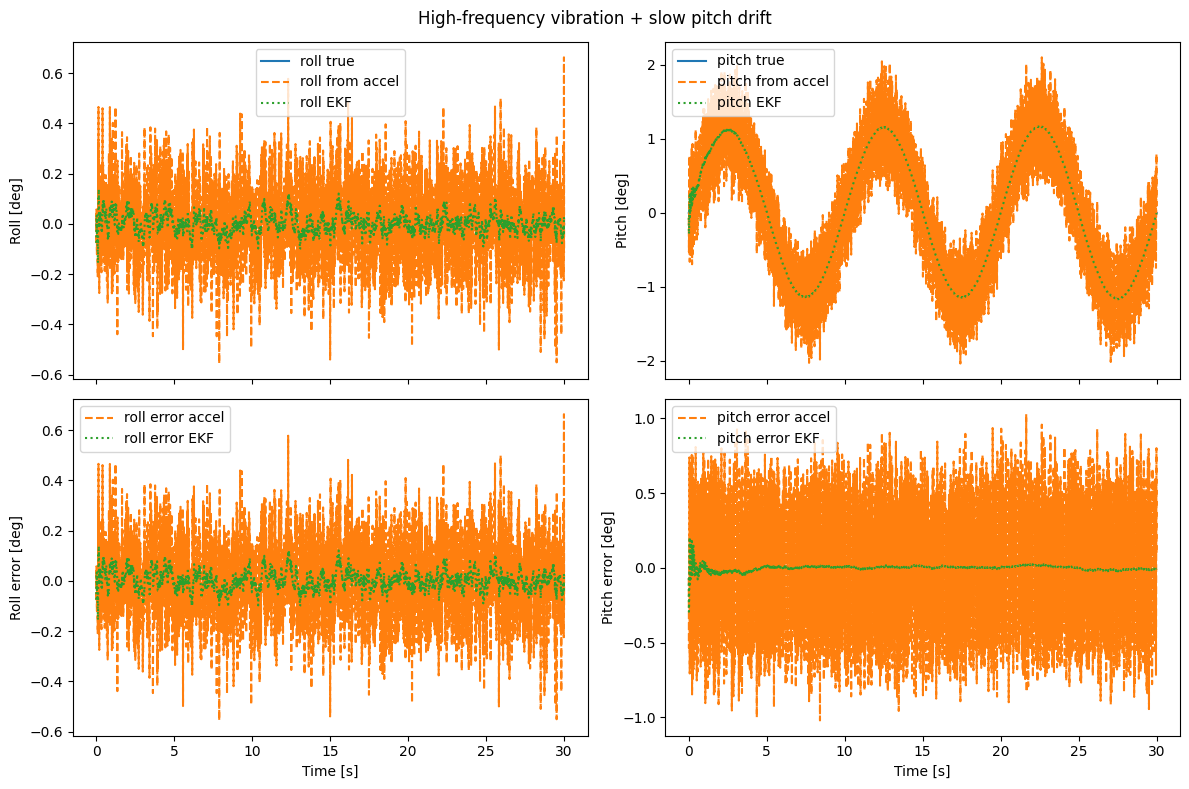

Final true angles   (deg): roll = 0.000, pitch = -0.000
Final accel angles  (deg): roll = -0.114, pitch = 0.088
Final EKF angles    (deg): roll = 0.014, pitch = -0.004
Final EKF biases (rad/s): bx = 0.0400, by = 0.0400, bz = 0.0378


In [9]:
profile = high_freq_vibration_profile(lin_accel_amp=0.1, vib_freq=20.0, pitch_rate=0.02)
result_vib = run_simulation(profile, T=30.0, dt=0.01, title="High-frequency vibration + slow pitch drift")

In [10]:
# from animation_helpers import animate_simulation
# from IPython.display import HTML

# anim_mixed = animate_simulation(result_mixed, title="Mixed linear + angular (animated)", speed=1.0)
# HTML(anim_mixed.to_jshtml())

In [11]:
# from animation_helpers import animate_simulation
# from IPython.display import HTML

# # Example: animated visualization for sinusoidal scenario
# profile = sinusoidal_orientation(roll_amp=0.1, roll_freq=0.5, pitch_amp=0.1, pitch_freq=0.7, yaw_rate=0.0)
# result = run_simulation(profile, T=10.0, dt=0.02, title="Sinusoidal roll/pitch")
# anim = animate_simulation(result, title="Sinusoidal roll/pitch (animated)")
# HTML(anim.to_jshtml())

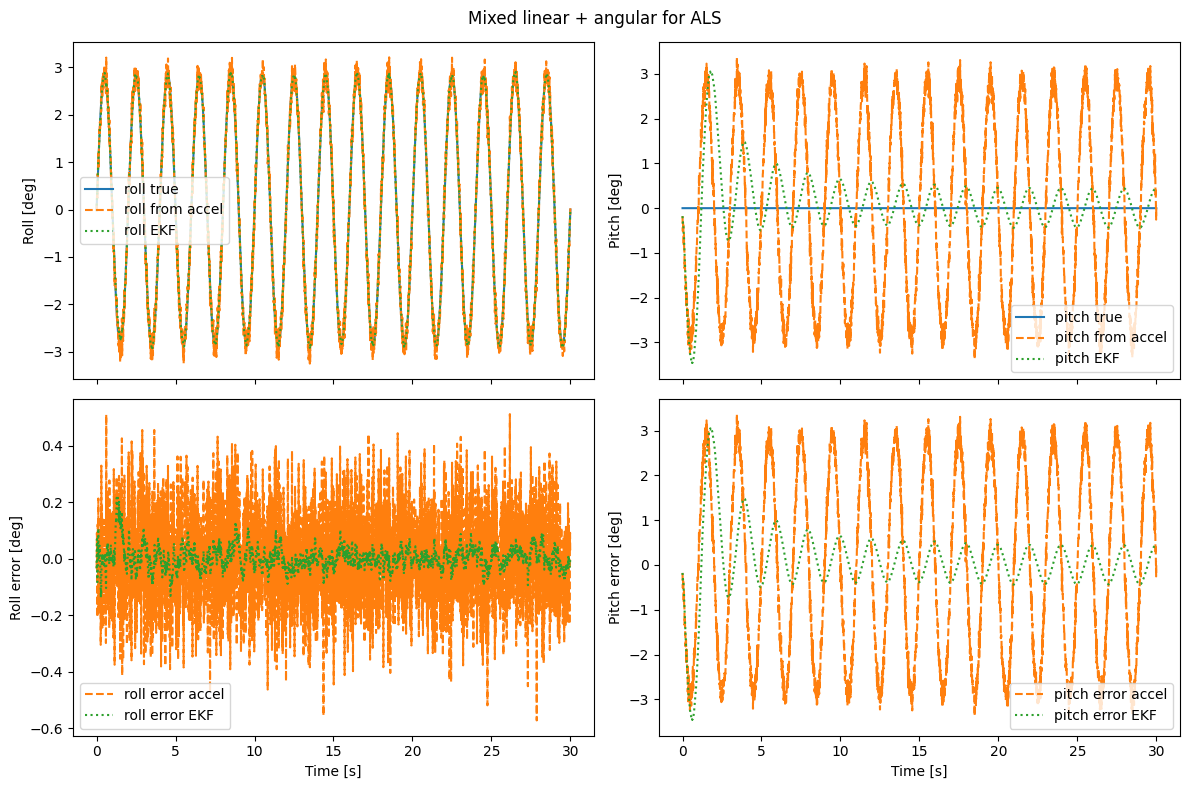

Final true angles   (deg): roll = -0.000, pitch = 0.000
Final accel angles  (deg): roll = 0.027, pitch = 0.070
Final EKF angles    (deg): roll = -0.001, pitch = 0.429
Final EKF biases (rad/s): bx = 0.0399, by = 0.0391, bz = 0.2597
dict_keys(['t', 'roll_true', 'pitch_true', 'yaw_true', 'roll_meas_acc', 'pitch_meas_acc', 'roll_est', 'pitch_est', 'bx_est', 'by_est', 'bz_est', 'roll_err_acc', 'roll_err_ekf', 'pitch_err_acc', 'pitch_err_ekf', 'accel', 'gyro'])


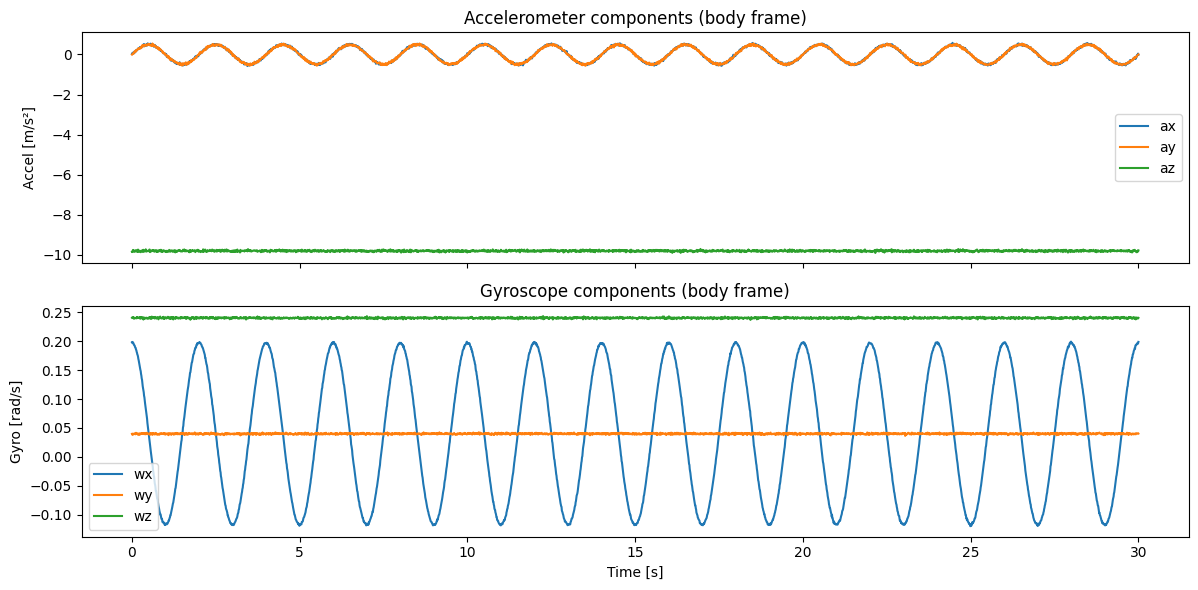

Sample innovation covariance C0:
[[ 1.02291698e-04 -2.38925059e-05]
 [-2.38925059e-05  7.44959752e-04]]
Suggested R from ALS (diag of C0):
r_roll ≈ 0.000102291698148123
r_pitch ≈ 0.0007449597520402432


In [12]:
# ALS-style estimation of R (and a hint about Q) from innovations
from ekf_inclinometer import InclinometerEKF, EKFConfig

# Run a scenario to generate innovation logs (e.g., mixed linear + angular)
profile = mixed_linear_angular_demo()
result_mixed = run_simulation(profile, T=30.0, dt=0.01, title="Mixed linear + angular for ALS")

print(result_mixed.keys())
t = result_mixed["t"]
accel = result_mixed["accel"]  # shape (N, 3)
gyro = result_mixed["gyro"]    # shape (N, 3)

fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axs[0].plot(t, accel[:, 0], label="ax")
axs[0].plot(t, accel[:, 1], label="ay")
axs[0].plot(t, accel[:, 2], label="az")
axs[0].set_ylabel("Accel [m/s²]")
axs[0].legend()
axs[0].set_title("Accelerometer components (body frame)")

axs[1].plot(t, gyro[:, 0], label="wx")
axs[1].plot(t, gyro[:, 1], label="wy")
axs[1].plot(t, gyro[:, 2], label="wz")
axs[1].set_ylabel("Gyro [rad/s]")
axs[1].set_xlabel("Time [s]")
axs[1].legend()
axs[1].set_title("Gyroscope components (body frame)")

plt.tight_layout()
plt.show()

# Access the EKF instance used in run_simulation by re-running with a handle
cfg = EKFConfig()
sim = InclinometerSim()
ekf_als = InclinometerEKF(cfg)

T_als = 30.0
dt_als = 0.01
N_als = int(T_als / dt_als)
t_als = np.linspace(0.0, T_als, N_als)

# Clear any previous logs
ekf_als.innovation_log.clear()
ekf_als.S_log.clear()

for k in range(N_als):
    tk = t_als[k]
    (roll, pitch, yaw), (ax_body, ay_body, az_body), (wx, wy, wz) = profile(tk)
    sim.set_orientation(roll, pitch, yaw)
    sim.set_angular_velocity_body(wx, wy, wz)
    sim.set_linear_accel_body(ax_body, ay_body, az_body)
    accel_meas = sim.read_accel()
    gyro_meas = sim.read_gyro()

    ekf_als.predict(gyro_meas, dt_als)
    roll_acc, pitch_acc = InclinometerSim.roll_pitch_from_accel(accel_meas)
    ekf_als.update((roll_acc, pitch_acc))

# Stack innovations into an array
v = np.stack(ekf_als.innovation_log)  # shape (N_als, 2)
v_mean = v.mean(axis=0, keepdims=True)
v0 = v - v_mean

# Sample innovation covariance at lag 0
C0 = (v0.T @ v0) / v0.shape[0]

print("Sample innovation covariance C0:")
print(C0)

# Approximate effective measurement noise R_eff from the diagonal of C0
R_eff_roll = float(C0[0, 0])
R_eff_pitch = float(C0[1, 1])

print("Suggested R from ALS (diag of C0):")
print("r_roll ≈", R_eff_roll)
print("r_pitch ≈", R_eff_pitch)


# You can plug these back into EKFConfig(r_roll=R_eff_roll, r_pitch=R_eff_pitch)
